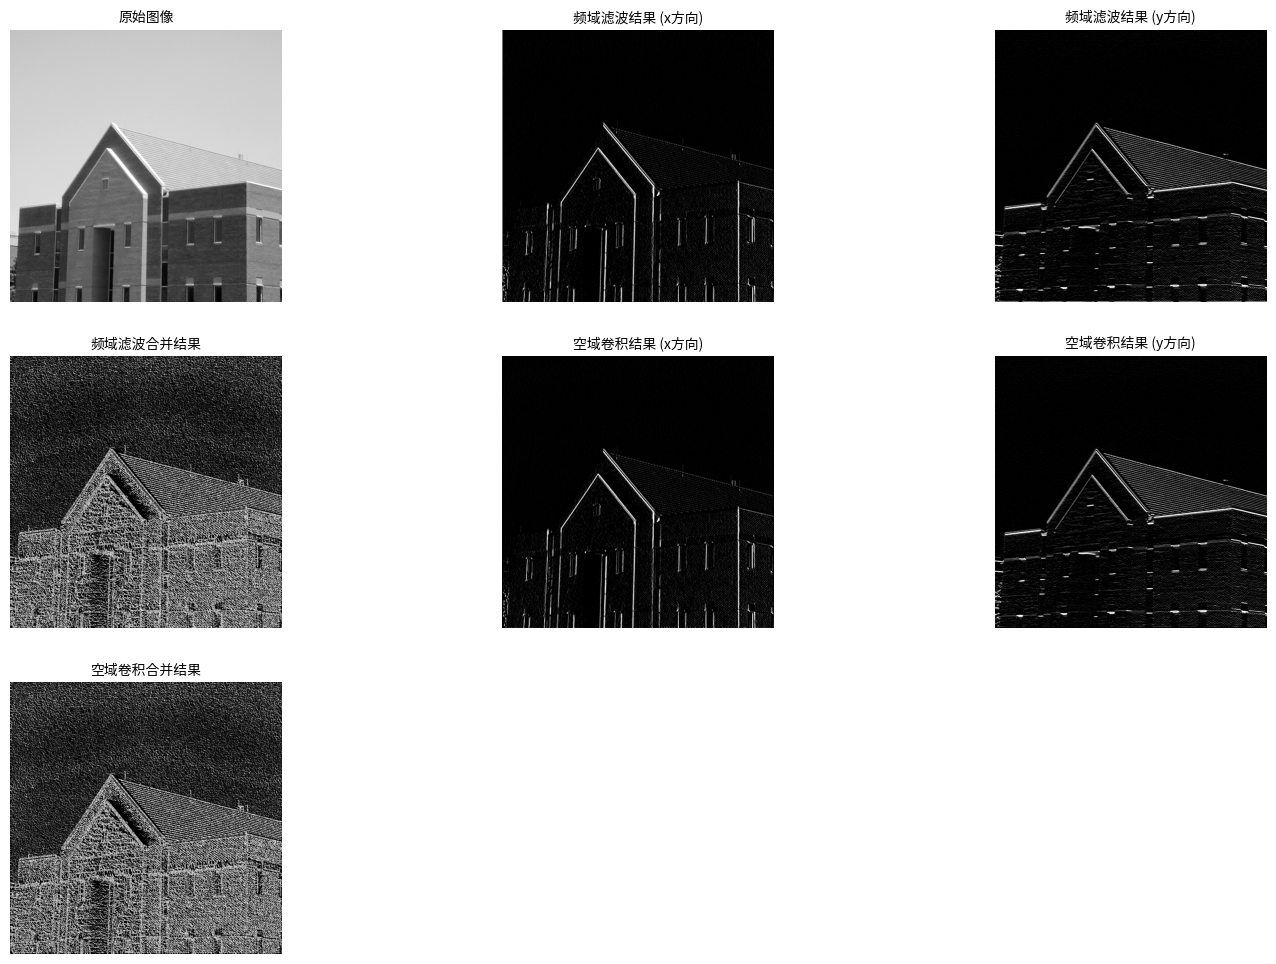

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# # 指定 Noto 字体路径
font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'  # 确保该路径是正确的
font_prop = fm.FontProperties(fname=font_path)


def get_Sobel_H(P, Q):
    """
    计算Sobel算子的传递函数 H(u,v).
    
    参数:
    P: 行数 (填充后的图像高度)
    Q: 列数 (填充后的图像宽度)
    
    返回:
    H_x: Sobel x方向的传递函数
    H_y: Sobel y方向的传递函数
    """
    # Sobel算子（水平和垂直部分）
   # 定义Sobel算子，方向为x
    # 注意：这里因为给的算子是做自相关计算的，根据数学定理，在频域上应该是取共轭后相乘
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]], dtype=np.float32)

    # 定义Sobel算子，方向为y
    # 同样，这里也使用相反的符号，目的是确保在频域和空域中的操作效果一致。
    # 负的y方向算子用于提取垂直方向的边缘（高亮显示亮度上升的边缘）。
    sobel_y = np.array([[1, 2, 1],
                        [0, 0, 0],
                        [-1, -2, -1]], dtype=np.float32)


    # 创建填充矩阵
    hp_x = np.zeros((P, Q), dtype=np.float32)
    hp_y = np.zeros((P, Q), dtype=np.float32)

    # 将Sobel算子放置到中心
    hp_x[P//2-1:P//2+2, Q//2-1:Q//2+2] = sobel_x
    hp_y[P//2-1:P//2+2, Q//2-1:Q//2+2] = sobel_y

    # 1. 进行频域中心化
    hp_x *= (-1) ** (np.indices(hp_x.shape)[0] + np.indices(hp_x.shape)[1])
    hp_y *= (-1) ** (np.indices(hp_y.shape)[0] + np.indices(hp_y.shape)[1])

    # 2. 计算DFT
    Hc_x = np.fft.fft2(hp_x)
    Hc_y = np.fft.fft2(hp_y)

    # 3. 解中心化
    Hc_x *= (-1) ** (np.indices(Hc_x.shape)[0] + np.indices(Hc_x.shape)[1])
    Hc_y *= (-1) ** (np.indices(Hc_y.shape)[0] + np.indices(Hc_y.shape)[1])

    # 4. 取共轭
    H_x = np.copy(Hc_x).conj()
    H_y = np.copy(Hc_y).conj()


    H_x.real = 0
    H_y.real = 0

    return H_x, H_y

def frequency_domain_filtering(H, image):
    M, N = image.shape

    # 2. 计算填充大小
    P = 2 * M
    Q = 2 * N

    # 3. 创建填充图像，并填充为0
    fp = np.zeros((P, Q), dtype=np.float32)
    fp[0:M, 0:N] = image

    # 4. 进行频域中心化
    fp *= (-1) ** (np.indices(fp.shape)[0] + np.indices(fp.shape)[1])

    # 5. 计算DFT
    F = np.fft.fft2(fp)

    # 7. 计算 G(u,v) = H(u,v) * F(u,v)
    G = H * F

    # 8. 计算逆DFT，得到过滤后的图像
    gp = np.fft.ifft2(G)

    # 9. 中心化逆变换结果
    gp *= (-1) ** (np.indices(gp.shape)[0] + np.indices(gp.shape)[1])

    # 10. 提取与原始图像相同大小的区域
    g = np.real(gp[0:M, 0:N])  # 取实部

    # 11. 归一化处理（0到255）
    g = np.clip(g, 0, 255).astype(np.uint8)

    # 12. 计算频谱的幅度
    F_magnitude = np.abs(F)
    F_magnitude_log = 20 * np.log(1 + F_magnitude)  # 对数变换以增强可视化效果

    # 计算滤波后的频谱幅度
    G_magnitude = np.abs(G)
    G_magnitude_log = 20 * np.log(1 + G_magnitude)  # 对数变换以增强可视化效果

  

    return g

# 使用示例
image = cv2.imread('Q5_1.tif', cv2.IMREAD_GRAYSCALE)
# 计算填充大小
M, N = image.shape
P = 2 * M
Q = 2 * N
H_x, H_y = get_Sobel_H(P, Q)  # 在调用函数前，需要先计算 H_x 和 H_y
frequency_result_x = frequency_domain_filtering(H_x, image)
frequency_result_y = frequency_domain_filtering(H_y, image)
frequency_result = np.sqrt(frequency_result_x**2 + frequency_result_y**2)  # 合并两个方向的结果
# 使用Sobel算子进行卷积
# Sobel x方向的卷积核
sobel_x = np.array([[-1, 0, 1],
                     [-2, 0, 2],
                     [-1, 0, 1]], dtype=np.float32)

# Sobel y方向的卷积核
sobel_y = np.array([[1, 2, 1],
                     [0, 0, 0],
                     [-1, -2, -1]], dtype=np.float32)


filtered_x = cv2.filter2D(image, -1, sobel_x)
filtered_y = cv2.filter2D(image, -1, sobel_y)
sobel_result = np.sqrt(filtered_x**2 + filtered_y**2)

# 绘制结果对比
plt.figure(figsize=(18, 12))

# 原始图像
plt.subplot(3, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('原始图像', fontproperties=font_prop)
plt.axis('off')

# 频域滤波结果
plt.subplot(3, 3, 2)
plt.imshow(frequency_result_x, cmap='gray')
plt.title('频域滤波结果 (x方向)', fontproperties=font_prop)
plt.axis('off')

plt.subplot(3, 3, 3)
plt.imshow(frequency_result_y, cmap='gray')
plt.title('频域滤波结果 (y方向)', fontproperties=font_prop)
plt.axis('off')

plt.subplot(3, 3, 4)
plt.imshow(frequency_result, cmap='gray')
plt.title('频域滤波合并结果', fontproperties=font_prop)
plt.axis('off')

# 空域卷积结果
plt.subplot(3, 3, 5)
plt.imshow(filtered_x, cmap='gray')
plt.title('空域卷积结果 (x方向)', fontproperties=font_prop)
plt.axis('off')

plt.subplot(3, 3, 6)
plt.imshow(filtered_y, cmap='gray')
plt.title('空域卷积结果 (y方向)', fontproperties=font_prop)
plt.axis('off')

plt.subplot(3, 3, 7)
plt.imshow(sobel_result, cmap='gray')
plt.title('空域卷积合并结果', fontproperties=font_prop)
plt.axis('off')

plt.show()


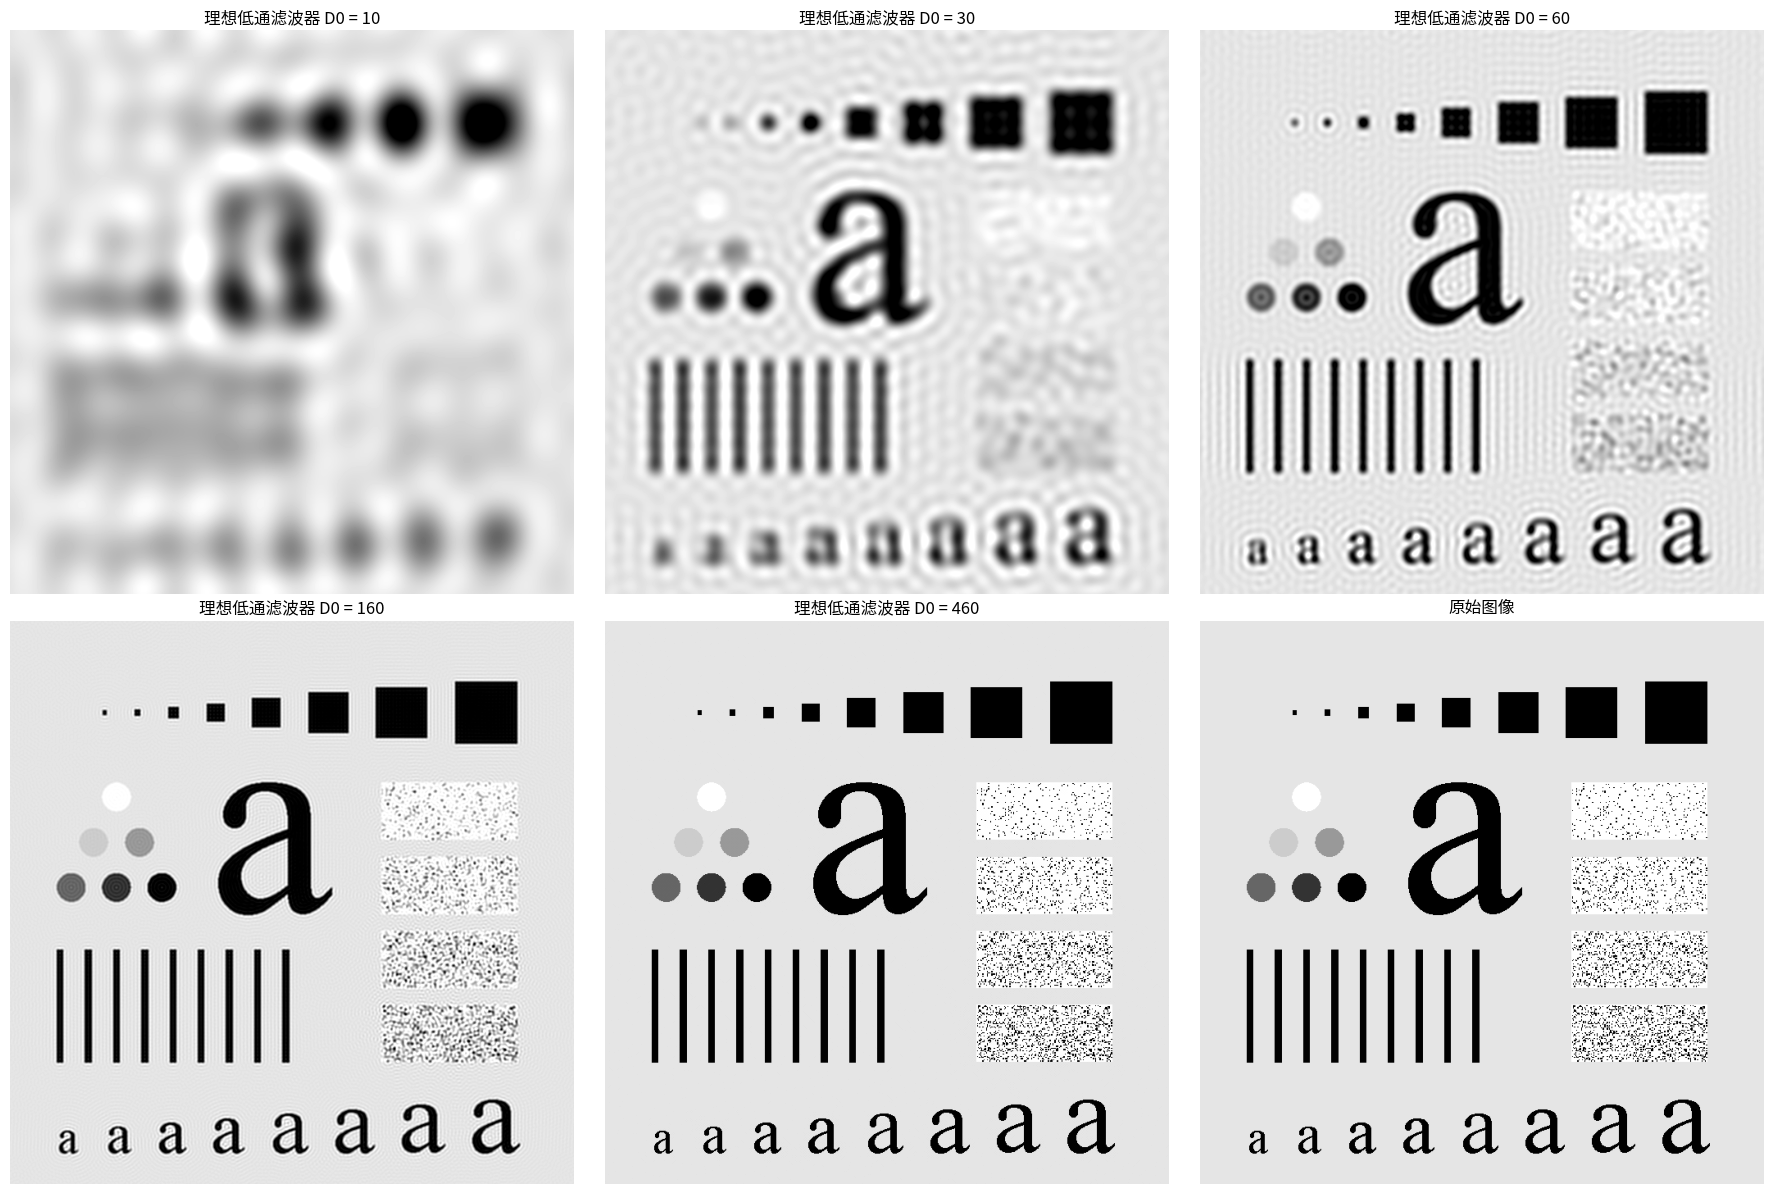

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import font_manager

font_path = '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc'  # 确保路径正确
font_prop = font_manager.FontProperties(fname=font_path)

# 设置全局字体
plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 显示负号
def ideal_lowpass_filter(image, D0):
    """
    实现理想低通滤波器
    :param image: 输入图像
    :param D0: 截止频率
    :return: 过滤后的图像
    """
    # 获取图像的大小
    M, N = image.shape
    # 进行DFT并中心化
    F = np.fft.fft2(image)
    F_shifted = np.fft.fftshift(F)

    # 创建低通滤波器
    # 生成网格坐标
    x = np.linspace(-N/2, N/2-1, N)
    y = np.linspace(-M/2, M/2-1, M)
    X, Y = np.meshgrid(x, y)

    # 计算每个点到中心的距离
    D = np.sqrt(X**2 + Y**2)
    # 创建理想低通滤波器
    H = np.zeros_like(D)
    H[D <= D0] = 1  # 在截止频率内的部分为1，其余部分为0

    # 应用滤波器
    G = H * F_shifted

    # 计算逆DFT并取实部
    gp = np.fft.ifftshift(G)
    filtered_image = np.fft.ifft2(gp)
    filtered_image = np.real(filtered_image)

    # 归一化处理以适应图像格式
    filtered_image = np.clip(filtered_image, 0, 255).astype(np.uint8)

    return filtered_image

# 读取输入图像
image = cv2.imread('Q5_2.tif', cv2.IMREAD_GRAYSCALE)

# 设置截止频率
D0_values = [10, 30, 60, 160, 460]

# 绘制结果
plt.figure(figsize=(18, 12))

# 对不同的截止频率进行过滤
for i, D0 in enumerate(D0_values):
    filtered_image = ideal_lowpass_filter(image, D0)
    
    # 绘制结果
    plt.subplot(2, 3, i + 1)
    plt.imshow(filtered_image, cmap='gray')
    plt.title(f'理想低通滤波器 D0 = {D0}', fontproperties=font_prop, fontsize=12)  # 使用字体属性
    plt.axis('off')

# 打开原始图像的子图
plt.subplot(2, 3, len(D0_values) + 1)
plt.imshow(image, cmap='gray')
plt.title('原始图像', fontproperties=font_prop, fontsize=12)  # 使用字体属性
plt.axis('off')

plt.tight_layout()
plt.show()

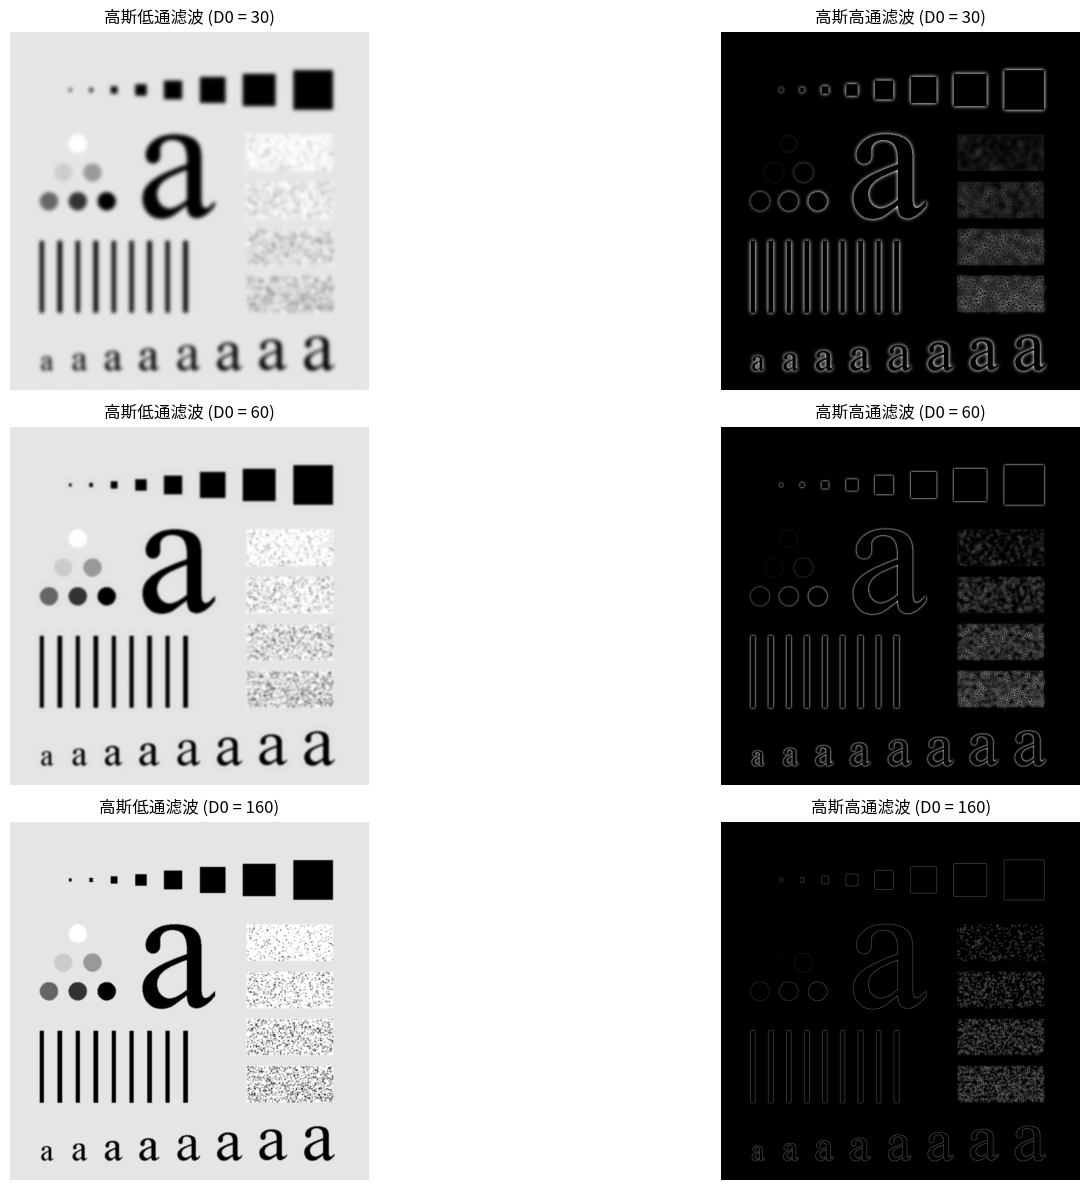

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def gaussian_lowpass_filter(image, D0):
    """
    实现高斯低通滤波器
    :param image: 输入图像
    :param D0: 截止频率
    :return: 过滤后的图像
    """
    M, N = image.shape
    F = np.fft.fft2(image)
    F_shifted = np.fft.fftshift(F)

    # 创建高斯低通滤波器
    # 创建从零开始的频率坐标
    u = np.linspace(0, N-1, N)  # 从0到N-1, 然后移到中心
    v = np.linspace(0, M-1, M)   # 从0到M-1, 然后移到中心
    U, V = np.meshgrid(u, v)

    # 计算到中心的距离 D
    D = np.sqrt((U-N/2)**2 + (V-M/2)**2)

    H = np.exp(-(D**2) / (2 * (D0**2)))

    # 应用滤波器
    G = H * F_shifted

    # 计算逆DFT并取实部
    gp = np.fft.ifftshift(G)
    filtered_image = np.fft.ifft2(gp)
    filtered_image = np.real(filtered_image)

    # 归一化处理以适应图像格式
    filtered_image = np.clip(filtered_image, 0, 255).astype(np.uint8)

    return filtered_image

def gaussian_highpass_filter(image, D0):
    """
    实现高斯高通滤波器
    :param image: 输入图像
    :param D0: 截止频率
    :return: 过滤后的图像
    """
    M, N = image.shape
    F = np.fft.fft2(image)
    F_shifted = np.fft.fftshift(F)

    # 创建高斯高通滤波器
    # 创建从零开始的频率坐标
    u = np.linspace(0, N-1, N) - N/2  # 从0到N-1, 然后移到中心
    v = np.linspace(0, M-1, M) - M/2  # 从0到M-1, 然后移到中心
    U, V = np.meshgrid(u, v)

    # 计算到中心的距离 D
    D = np.sqrt((U)**2 + (V)**2)

    H = 1 - np.exp(-(D**2) / (2 * (D0**2)))  # 高通滤波器为1减去低通

    # 应用滤波器
    G = H * F_shifted

    # 计算逆DFT并取实部
    gp = np.fft.ifftshift(G)
    filtered_image = np.fft.ifft2(gp)
    filtered_image = np.real(filtered_image)

    # 归一化处理以适应图像格式
    filtered_image = np.clip(filtered_image, 0, 255).astype(np.uint8)

    return filtered_image

# 读取输入图像
image = cv2.imread('Q5_2.tif', cv2.IMREAD_GRAYSCALE)

# 设置截止频率
D0_values = [30, 60, 160]

# 创建图形
plt.figure(figsize=(18, 12))

# 对不同的截止频率进行高斯低通滤波
for i, D0 in enumerate(D0_values):
    filtered_image_lp = gaussian_lowpass_filter(image, D0)

    # 绘制结果
    plt.subplot(3, 2, 2 * i + 1)
    plt.imshow(filtered_image_lp, cmap='gray')
    plt.title(f'高斯低通滤波 (D0 = {D0})', fontsize=12)
    plt.axis('off')

# 对不同的截止频率进行高斯高通滤波
for i, D0 in enumerate(D0_values):
    filtered_image_hp = gaussian_highpass_filter(image, D0)

    # 绘制结果
    plt.subplot(3, 2, 2 * i + 2)
    plt.imshow(filtered_image_hp, cmap='gray')
    plt.title(f'高斯高通滤波 (D0 = {D0})', fontsize=12)
    plt.axis('off')

# 显示图形
plt.tight_layout()
plt.show()


/tmp/ipykernel_16549/2942000433.py:103: UserWarning: Glyph 21407 (\N{CJK UNIFIED IDEOGRAPH-539F}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16549/2942000433.py:103: UserWarning: Glyph 22987 (\N{CJK UNIFIED IDEOGRAPH-59CB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16549/2942000433.py:103: UserWarning: Glyph 22270 (\N{CJK UNIFIED IDEOGRAPH-56FE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16549/2942000433.py:103: UserWarning: Glyph 20687 (\N{CJK UNIFIED IDEOGRAPH-50CF}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16549/2942000433.py:103: UserWarning: Glyph 21450 (\N{CJK UNIFIED IDEOGRAPH-53CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16549/2942000433.py:103: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_16549/2942000433.py:103: UserWarning: Glyph 25928 (\N{CJK UNIFIED I

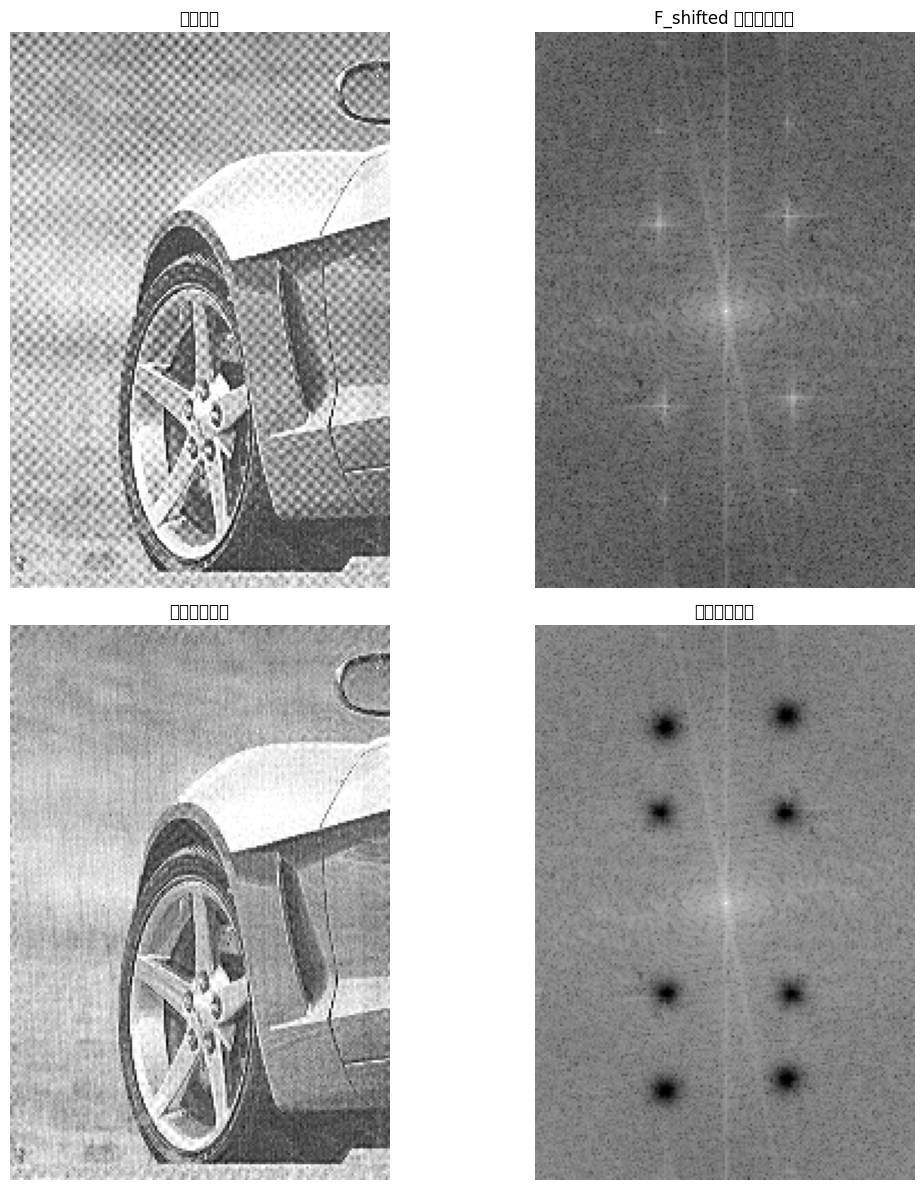

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def butterworth_notch_filter(image, D0, n, notch_centers):
    M, N = image.shape
    F = np.fft.fft2(image)
    F_shifted = np.fft.fftshift(F)

    u = np.linspace(0, N-1, N)
    v = np.linspace(0, M-1, M)
    U, V = np.meshgrid(u, v)

    H_total = np.ones((M, N))

    for center in notch_centers:
        D_k = np.sqrt((U - N / 2 - center[0])**2 + (V - M / 2 - center[1])**2) + 1e-10
        D_kk = np.sqrt((U - N / 2 + center[0])**2 + (V - M / 2 + center[1])**2) + 1e-10

        H = 1 / (1 + (D0 / D_k)**(2 * n)) * (1 / (1 + (D0 / D_kk)**(2 * n)))
        H[np.isnan(H)] = 0
        H_total *= H

    G = H_total * F_shifted

    gp = np.fft.ifftshift(G)
    filtered_image = np.fft.ifft2(gp)
    filtered_image = np.real(filtered_image)
    filtered_image = np.clip(filtered_image, 0, 255).astype(np.uint8)

    return filtered_image, H_total, F_shifted, G

# 读取输入图像
image = cv2.imread('Q5_3.tif', cv2.IMREAD_GRAYSCALE)
M, N = image.shape

D0 = 10
n = 3
notch_centers = [(29, 40), (-26.5, 40), (27, 78), (-27, 83)]

# 执行滤波
filtered_image, H_total, F_shifted, G = butterworth_notch_filter(image, D0, n, notch_centers)

# 删除中心周围的值
center_x, center_y = N // 2, M // 2
radius = 10
Y, X = np.ogrid[:M, :N]
mask = (X - center_x)**2 + (Y - center_y)**2 <= radius**2
F_shifted_masked = np.copy(F_shifted)
F_shifted_masked[mask] = 0

# 找到最大的10个值的坐标
top_indices = np.argsort(np.abs(F_shifted_masked).flatten())[-50:]  # 找到前50个值的索引
top_coordinates = np.unravel_index(top_indices, F_shifted_masked.shape)

# 使用集合来存储有效的最大值（忽略相近的点）
valid_points = []

# 设置最小距离
min_distance = 10  # 定义最小距离

# for i in range(len(top_coordinates[0])):
#     current_point = (top_coordinates[0][i], top_coordinates[1][i])
#     if all(np.linalg.norm(np.array(current_point) - np.array(point)) >= min_distance for point in valid_points):
#         valid_points.append(current_point)

# 创建可视化图像并归一化到0-255
F_shifted_vis = np.log1p(np.abs(F_shifted))
F_shifted_vis = (F_shifted_vis / F_shifted_vis.max() * 255).astype(np.uint8)

# 用 plt 画圈
plt.figure(figsize=(12, 12))

# 显示原图
plt.subplot(2, 2, 1)  
plt.imshow(image, cmap='gray')
plt.title('原始图像', fontsize=12)
plt.axis('off')

# 显示F_shifted并标记有效最大值
plt.subplot(2, 2, 2)
plt.imshow(F_shifted_vis, cmap='gray')
for max_y, max_x in valid_points:
    circle = plt.Circle((max_x, max_y), 5, color='red', fill=False, linewidth=2)
    plt.gca().add_patch(circle)
plt.title('F_shifted 及有效最大值', fontsize=12)
plt.axis('off')

# 显示过滤后的图像
plt.subplot(2, 2, 3)
plt.imshow(filtered_image, cmap='gray')
plt.title('过滤后的图像', fontsize=12)
plt.axis('off')

# 显示滤波后的频谱
plt.subplot(2, 2, 4)  # 添加过滤后的频谱的子图
G_vis = np.log1p(np.abs(G))  # 对滤波后的频谱取对数
G_vis = (G_vis / G_vis.max() * 255).astype(np.uint8)  # 归一化到0-255
plt.imshow(G_vis, cmap='gray')
plt.title('滤波后的频谱', fontsize=12)
plt.axis('off')

plt.tight_layout()
plt.show()
